In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.decomposition import PCA as RandomizedPCA
from util import *

In [2]:
import torch
from pyspade_global import *


In [3]:
import scanpy as sc

In [46]:
DATA_DIR = '//path_to_data/'
fig_save_path ='/path_to_data/'

In [47]:
color_map_clusters_nogrey = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

batlow_20 = ['#1d2356','#1d2b59',
'#14375e',
'#134460',
'#1c5261',
'#235f5f',
'#396a58',
'#4c714e',
'#607843',
'#757e36',
'#8d8532',
'#a78b30',
'#c49138',
'#dc954d',
'#f09c6a',
'#f8a487',
'#f8aca2',
'#f8b5be',
'#f8c2d9',
'#eecbe1'] 
import random
random.seed(1)
random.shuffle(batlow_20)

blue_red = ['#0E518F','#DF480F']


In [80]:
def randomize_cells(anndata_object):
    "Randomize cells for plotting "
    index_list = np.arange(anndata_object.shape[0])
    np.random.shuffle(index_list)
    anndata_object = anndata_object[index_list]
    return anndata_object

In [43]:
def overlap_coefficient(set_a,set_b):
    min_len = min([len(set_a),len(set_b)])
    intersect_len = len(set_a.intersection(set_b))
    overlap = intersect_len/min_len
    return overlap


In [44]:
def label_marker_genes(marker_genes, gs_label_dict, threshold = 0.4):
    '''
    label an array of marker genes using a KnowledgeBase or a dictionary derived from the KnowledgeBase
    returns a dataframe of overlap coefficients for each gene set annotation and marker gene
    marker_genes: array factors x marker genes or a KnowledgeBase object
    label an array containing marker genes by its overlap with a dictionary of gene sets from the knowledge base:
    KnowledgeBase.celltype_process_dict
    '''
    import numpy as np
    import warnings

    if isinstance(gs_label_dict,cytopus.kb.kb_queries.KnowledgeBase):
        #collapse annotation dict
        gs_dict = {}
        key_list = []
        for key, value in gs_label_dict.celltype_process_dict.items():
            for k,v in value.items():
                if k not in key_list:
                    gs_dict[k]=v
                    key_list.append(k)
    else:
        gs_dict = gs_label_dict
    if threshold <=0.5:
        warnings.warn('threshold <= 0.5 can resolve in ties, consider using higher threshold or manually check for ties in  overlap_df output')
    overlap_df = pd.DataFrame()
    for i, v in pd.DataFrame(marker_genes).T.iteritems():
        for gs_name, gs in gs_dict.items():
            overlap_df.loc[i,gs_name] =  overlap_coefficient(set(gs),set(v))
    marker_gene_labels = [] #gene sets
    for marker_set in overlap_df.index:
        max_overlap = overlap_df.loc[marker_set].sort_values().index[-1]
        if overlap_df.loc[marker_set].sort_values().values[-1] >threshold:
            marker_gene_labels.append(max_overlap)
        else:
            marker_gene_labels.append(marker_set)
    overlap_df.index = marker_gene_labels     
        
    return overlap_df

In [45]:
def aggregate_cell_scores(adata,clinical_var_obs,clinical_var2_obs,factor_name_list_corr,batch_key,patient_obs,
                            obs_columns,
                            zero_cutoff =0.001):
    '''
    aggregate factor cell scores per batch/patient:
    clinical_var_obs: for later fold change calculation --> #obs for clinical variable to calculate fold change over
    clinical_var2_obs #additional clinical variable
    patient_obs #key for patient id in adata.obs 
    batch_key #key for batch / sample in adata.obs
    factor_name_list_corr #list with factors to calculate fold change for
    zero_cutoff #mean of positive fraction per factor will be calculated, define threshold for positive frac if None mean without any cutoff will be calculated 
     obs_columns: name for columns in output dataframe (order will be clinical_var_obs, clinical_var2_obs, partient_obs)
    '''
    #first calculate mean of positive fraction for each sample
    df_batches = pd.DataFrame()

    for j in set(adata.obs[batch_key]):
        adata_subset = adata[adata.obs[batch_key]==j]
        clinical_var = list(set(adata_subset.obs[clinical_var_obs]))[0]
        clinical_var2 = list(set(adata_subset.obs[clinical_var2_obs]))[0]
        patient = list(set(adata_subset.obs[patient_obs]))[0]

        #define here which metric you want to use
        for i in factor_name_list_corr:
            #greater_zero = list(set(adata_CD8_subset.obs[i] > zero_cutoff))
            #if greater_zero[0] == False and len(greater_zero) == 1:
             #   a = 0 #set 0 if all loadings are 0
            #else:
            #a = scipy.stats.mstats.gmean(adata_CD8_pre.obs[i])
            #a = len(adata_CD8_pre.obs[adata_CD8_pre.obs[i] >zero_cutoff])/len(adata_CD8_pre.obs[i])
            #a = scipy.stats.mstats.gmean(adata_CD8_subset.obs[adata_CD8_subset.obs[i] >zero_cutoff][i])
            if zero_cutoff == None:
                a = np.mean(adata_subset.obs[i])
            else:
                a = np.mean(adata_subset.obs[adata_subset.obs[i] >zero_cutoff][i])
            #a = np.mean(adata_CD8_pre.obs[i])

            df_batches.loc[j,i]=a
            df_batches.loc[j,obs_columns[0]] = clinical_var
            df_batches.loc[j,obs_columns[1]] = clinical_var2
            df_batches.loc[j,obs_columns[2]] = patient
    

    return df_batches


# load model file

In [5]:
DATA_DIR = '/path_to_data/'

In [6]:
adata_path = DATA_DIR+ 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_lambda0.01_lambda0.01_rho0.05_kappaNone_delta0.001.h5ad'
adata_save_path = DATA_DIR+ 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_lambda0.01_lambda0.01_rho0.05_kappaNone_delta0.001_SLALOM.h5ad'
model_path = DATA_DIR + 'slalom_cytokines.pickle'
csv_save_path = DATA_DIR+ 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_lambda0.01_lambda0.01_rho0.05_kappaNone_delta0.001_SLALOM_marker_genes.csv'

In [8]:
#if error with sk learn comment this out from the SLALOM utils.py file
with open(model_path, 'rb') as f:
    x = pickle.load(f)

In [9]:
adata= sc.read(adata_path)


Only considering the two last: ['.001', '.h5ad'].
Only considering the two last: ['.001', '.h5ad'].


In [10]:
loadings = x.getX()
factor_matrix = x.getW()*x.getZ()

In [11]:
factor_matrix.shape

(10027, 13)

In [12]:
#idx_matrix = np.argsort(factor_matrix.T,axis = 1)[:,::-1][:,:50]
idx_matrix = np.argsort(factor_matrix.T,axis = 1)[:,::-1] #all markers
idx_matrix

array([[5731, 2632, 2043, ..., 6767, 5006, 2504],
       [5006,  237, 8643, ..., 6767, 2504, 8179],
       [1590, 9943, 4127, ..., 4859, 8871,  700],
       ...,
       [8970, 1866, 8185, ..., 3848, 1640, 4182],
       [2058, 7388, 2536, ..., 3897, 8405, 9925],
       [6715,  130,  697, ..., 3598, 4005, 8124]])

In [13]:
idx_matrix.shape

(13, 10027)

In [20]:
idx_matrix

array([[5731, 2632, 2043, ..., 6767, 5006, 2504],
       [5006,  237, 8643, ..., 6767, 2504, 8179],
       [1590, 9943, 4127, ..., 4859, 8871,  700],
       ...,
       [8970, 1866, 8185, ..., 3848, 1640, 4182],
       [2058, 7388, 2536, ..., 3897, 8405, 9925],
       [6715,  130,  697, ..., 3598, 4005, 8124]])

In [18]:
adata

AnnData object with n_obs × n_vars = 23754 × 19004
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'spectra_vocab'
    uns: 'SPECTRA_L', 'SPECTRA_factors', 'SPECTRA_markers', 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'pheno_var_k40_colors', 'tsne', 'umap'
    obsm: 'SPECTRA_cell_scores', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'imputed', 'raw'
    obsp: 'connectivities', 'distances'

In [23]:
vocab =  np.load(DATA_DIR+'slalom_vocab.npy', allow_pickle=True)
vocab

array(['RNFT2', 'ZNF501', 'MAP1LC3B', ..., 'GUCY1B3', 'INPP5F', 'CCDC50'],
      dtype=object)

In [25]:
id2word = dict((idx, v) for idx, v in enumerate(vocab))
id2word

{0: 'RNFT2',
 1: 'ZNF501',
 2: 'MAP1LC3B',
 3: 'ATP2B2',
 4: 'UBE2G1',
 5: 'SVIL-AS1',
 6: 'KLHL25',
 7: 'TGFB1',
 8: 'C9orf142',
 9: 'ADGRG5',
 10: 'RRM2B',
 11: 'LOC646903',
 12: 'CDC14B',
 13: 'LOC648987',
 14: 'ARMC2',
 15: 'URB2',
 16: 'DBN1',
 17: 'DGUOK-AS1',
 18: 'KLHL26',
 19: 'THAP7-AS1',
 20: 'PDSS2',
 21: 'NAA25',
 22: 'STX16',
 23: 'CCL17',
 24: 'LGALS9',
 25: 'ZNF704',
 26: 'CECR5',
 27: 'HLA-E',
 28: 'PPAN',
 29: 'HPS1',
 30: 'ZNF569',
 31: 'PCSK5',
 32: 'CRCP',
 33: 'ZNF175',
 34: 'LCMT1',
 35: 'C2orf88',
 36: 'TBC1D9B',
 37: 'IL1RL1',
 38: 'UBE2F',
 39: 'AGAP4',
 40: 'GLTPD2',
 41: 'CRB3',
 42: 'MRS2P2',
 43: 'F13A1',
 44: 'CEBPA',
 45: 'MAST3',
 46: 'C6orf106',
 47: 'JAM3',
 48: 'SALL2',
 49: 'CD79B',
 50: 'MIR4469',
 51: 'PGBD4',
 52: 'CXXC4',
 53: 'GHRL',
 54: 'EPS15L1',
 55: 'GYPC',
 56: 'ULK3',
 57: 'SAT1',
 58: 'TTYH2',
 59: 'TMEM129',
 60: 'NOB1',
 61: 'CHN2',
 62: 'TIMP3',
 63: 'PNP',
 64: 'EPSTI1',
 65: 'ZNF17',
 66: 'INVS',
 67: 'FKBP14',
 68: 'ANAPC1P1',
 69

In [26]:
#convert top gene ids into top gene names and add to adata
marker_gene_df = pd.DataFrame(idx_matrix,index=['SLALOM_' + str(x) for x in list(range(idx_matrix.shape[0]))]).applymap(lambda x: id2word[x]).T
adata.uns['SLALOM_markers_global'] = marker_gene_df.to_dict(orient='list')



In [ ]:
marker_gene_df.to_csv(csv_save_path)
print('saved markers to:',csv_save_path)

In [29]:
adata

AnnData object with n_obs × n_vars = 23754 × 19004
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'spectra_vocab'
    uns: 'SPECTRA_L', 'SPECTRA_factors', 'SPECTRA_markers', 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'pheno_var_k40_colors', 'tsne', 'umap', 'SLALOM_markers_global'
    obsm: 'SPECTRA_cell_scores', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'imputed', 'raw'
    obsp: 'connectivities', 'distances'

In [30]:
#prepare loading df and store in adata
loading_df = pd.DataFrame(loadings,index=adata.obs_names, columns=['SLALOM_' + str(x) for x in list(range(idx_matrix.shape[0]))])



In [31]:
#add loadings
for i in loading_df.columns:
    adata.obs[i] = loading_df.loc[:,i]
    print('added',i,'to adata')

added SLALOM_0 to adata
added SLALOM_1 to adata
added SLALOM_2 to adata
added SLALOM_3 to adata
added SLALOM_4 to adata
added SLALOM_5 to adata
added SLALOM_6 to adata
added SLALOM_7 to adata
added SLALOM_8 to adata
added SLALOM_9 to adata
added SLALOM_10 to adata
added SLALOM_11 to adata
added SLALOM_12 to adata


In [ ]:
adata.write(adata_save_path)
print('saved adata to:',adata_save_path)

# plot cytokine perturbations

In [22]:
import scanpy as sc
import scanpy.external as sce

import pandas as pd
import scipy
import anndata
from scanpy.external.pp import magic
import cytopus as cp
import matplotlib.pyplot as plt

In [23]:
working_dir ='/path_to_data/'

In [24]:
import seaborn as sns

In [25]:
from scrnaseq_preprocessing_utils import *


In [ ]:
from SPECTRA_processing_utils import *

In [48]:
def two_sample_test(df,data_column, comparison_column,sample_column=None, test='matched-pairs-signed-rank'):
    '''
    perform a two-sample test between two groups in a dataframe
    df, pandas.DataFrame containing the data and columns with the boolean categories to compare 'comparison_column' and 
    'sample_column' containing the samples (necessary for paired test only)
    data_column: str, column in df containing the data
    comparison_column: str, column in df containing the boolean Categories to be compared
    sample_column: str, column in df containing the sample identity (categorical)
    test: str, indicating type of test
    returns: test result (scipy object), effect size (list)
    '''
    import pandas as pd
    import scipy
    import numpy as np
    if test=='matched-pairs-signed-rank' and sample_column==None:
        raise ValueError('You must provide the name of the column containing the sample information if test=<matched-pairs-signed-rank>')
    df_subset_1 = df[df[comparison_column]]
    df_subset_2 = df[~df[comparison_column]]
    if test=='matched-pairs-signed-rank':
        #make sure samples are identical for matched pairs test
        intersection = set(df_subset_1[sample_column]).intersection(set(df_subset_2[sample_column]))
        complement = set(df_subset_1[sample_column]).difference(set(df_subset_2[sample_column]))
        print('filtering out samples:',complement)
        df_subset_1 = df_subset_1[df_subset_1[sample_column].isin(intersection)].sort_values(sample_column)
        df_subset_2 = df_subset_2[df_subset_2[sample_column].isin(intersection)].sort_values(sample_column)
        #double check samples are identical
        print('samples are identical:',list(df_subset_1[sample_column])==list(df_subset_2[sample_column]))
    #get values
    a = list(df_subset_1[data_column])
    b = list(df_subset_2[data_column])
    #compare
    if test=='matched-pairs-signed-rank':
        test = scipy.stats.wilcoxon(a, b, zero_method='wilcox', correction=False, 
                         alternative='two-sided',  axis=0, 
                         nan_policy='propagate')
        effect = (np.mean(a)- np.mean(b))/np.std(a+b)
    return test, effect

# data 

In [32]:
adata_path = DATA_DIR + 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_lambda0.01_lambda0.01_rho0.05_kappaNone_delta0.001_SLALOM.h5ad'

In [33]:
adata = sc.read(adata_path)
adata

Only considering the two last: ['.001_SLALOM', '.h5ad'].
Only considering the two last: ['.001_SLALOM', '.h5ad'].


AnnData object with n_obs × n_vars = 23754 × 19004
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation', 'SLALOM_0', 'SLALOM_1', 'SLALOM_2', 'SLALOM_3', 'SLALOM_4', 'SLALOM_5', 'SLALOM_6', 'SLALOM_7', 'SLALOM_8', 'SLALOM_9', 'SLALOM_10', 'SLALOM_11', 'SLALOM_12'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'spectra_vocab'
    uns: 'SLALOM_markers_global', 'SPECTRA_L', 'SPECTRA_factors', 'SPECTRA_markers', 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'pheno_var_k40_colors', 'tsne', 'umap'
    obsm: 'SPECTRA_cell_scores', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    laye

In [34]:
import cytopus
G = cytopus.kb.KnowledgeBase()

KnowledgeBase object containing 75 cell types and 201 cellular processes



In [36]:
#reduce gene set dict to gene sets used for Slalom
Slalom_list = ['Mac_LPS-IFNG_invitro_response',
'all_type-II-ifn-response',
'T_tcr-activation']

process_dict = {}
for k,v in G.processes.items():
    if k in Slalom_list:
        process_dict[k]=v


In [40]:
#restrict to top 50 markers like for Spectra
Slalom_factors = ['SLALOM_0','SLALOM_1','SLALOM_2','SLALOM_3','SLALOM_4','SLALOM_5','SLALOM_6','SLALOM_7','SLALOM_8',
                 'SLALOM_9','SLALOM_10','SLALOM_11','SLALOM_12']
factor_list = []
for i in Slalom_factors:
    factor_list.append(list(adata.uns['SLALOM_markers_global'][i])[0:50])
                       
adata.uns['SLALOM_markers_global'] = np.array(factor_list)

In [49]:
overlap_df = label_marker_genes(adata.uns['SLALOM_markers_global'], process_dict, threshold = 0.2)
overlap_df

/scratch/lsftmp/17667690.tmpdir/ipykernel_466815/1189395551.py:24: UserWarning: threshold <= 0.5 can resolve in ties, consider using higher threshold or manually check for ties in  overlap_df output
  warnings.warn('threshold <= 0.5 can resolve in ties, consider using higher threshold or manually check for ties in  overlap_df output')
/scratch/lsftmp/17667690.tmpdir/ipykernel_466815/1189395551.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, v in pd.DataFrame(marker_genes).T.iteritems():


,T_tcr-activation,Mac_LPS-IFNG_invitro_response,all_type-II-ifn-response
0,0.10,0.047619,0.000000
1,0.12,0.000000,0.058824
2,0.06,0.047619,0.000000
3,0.02,0.000000,0.058824
4,0.00,0.047619,0.176471
all_type-II-ifn-response,0.00,0.000000,0.411765
all_type-II-ifn-response,0.00,0.000000,0.235294
7,0.00,0.000000,0.000000
all_type-II-ifn-response,0.00,0.000000,0.352941
9,0.12,0.190476,0.000000


In [51]:
#reformat SLALOM cell scores

SLALOM_factors = ['SLALOM_0', 'SLALOM_1', 'SLALOM_2', 'SLALOM_3', 'SLALOM_4', 'SLALOM_5', 'SLALOM_6', 'SLALOM_7', 'SLALOM_8', 'SLALOM_9', 'SLALOM_10', 'SLALOM_11', 'SLALOM_12']

SLALOM_cellscores = []
for i in SLALOM_factors:
    SLALOM_cellscores.append(list(adata.obs[i]))

SLALOM_cellscores = np.array(SLALOM_cellscores)
SLALOM_cellscores = np.transpose(SLALOM_cellscores)
adata.obsm['SLALOM_cell_scores'] =SLALOM_cellscores

In [52]:
#add index to make labels unique
new_index =[]
for h,i in enumerate(overlap_df.index):
    new_index.append(str(h)+'-X-'+str(i))
    
overlap_df.index = new_index

In [53]:
adata.obsm['SLALOM_cell_scores_df'] = pd.DataFrame(adata.obsm['SLALOM_cell_scores'],columns=overlap_df.index,index=adata.obs_names)

In [54]:
#add cell score to adata.obs
for i in adata.obsm['SLALOM_cell_scores_df'].columns:
    adata.obs[i] = list(adata.obsm['SLALOM_cell_scores_df'][i])
    

In [55]:
overlap_df['all_type-II-ifn-response'].sort_values()

0-X-0                                 0.000000
2-X-2                                 0.000000
7-X-7                                 0.000000
9-X-9                                 0.000000
12-X-T_tcr-activation                 0.000000
1-X-1                                 0.058824
3-X-3                                 0.058824
10-X-Mac_LPS-IFNG_invitro_response    0.058824
11-X-11                               0.058824
4-X-4                                 0.176471
6-X-all_type-II-ifn-response          0.235294
8-X-all_type-II-ifn-response          0.352941
5-X-all_type-II-ifn-response          0.411765
Name: all_type-II-ifn-response, dtype: float64

In [56]:
overlap_df['T_tcr-activation'].sort_values()

4-X-4                                 0.00
5-X-all_type-II-ifn-response          0.00
6-X-all_type-II-ifn-response          0.00
7-X-7                                 0.00
8-X-all_type-II-ifn-response          0.00
11-X-11                               0.00
3-X-3                                 0.02
2-X-2                                 0.06
0-X-0                                 0.10
10-X-Mac_LPS-IFNG_invitro_response    0.10
1-X-1                                 0.12
9-X-9                                 0.12
12-X-T_tcr-activation                 0.74
Name: T_tcr-activation, dtype: float64

In [57]:
overlap_df['Mac_LPS-IFNG_invitro_response'].sort_values()

1-X-1                                 0.000000
3-X-3                                 0.000000
5-X-all_type-II-ifn-response          0.000000
6-X-all_type-II-ifn-response          0.000000
7-X-7                                 0.000000
8-X-all_type-II-ifn-response          0.000000
11-X-11                               0.000000
0-X-0                                 0.047619
2-X-2                                 0.047619
4-X-4                                 0.047619
12-X-T_tcr-activation                 0.095238
9-X-9                                 0.190476
10-X-Mac_LPS-IFNG_invitro_response    0.333333
Name: Mac_LPS-IFNG_invitro_response, dtype: float64

In [58]:
factors_of_interest =['10-X-Mac_LPS-IFNG_invitro_response','12-X-T_tcr-activation','5-X-all_type-II-ifn-response']
factors_of_interest

['10-X-Mac_LPS-IFNG_invitro_response',
 '12-X-T_tcr-activation',
 '5-X-all_type-II-ifn-response']

In [59]:
adata.obsm['SLALOM_cell_scores_df']

,0-X-0,1-X-1,2-X-2,3-X-3,4-X-4,5-X-all_type-II-ifn-response,6-X-all_type-II-ifn-response,7-X-7,8-X-all_type-II-ifn-response,9-X-9,10-X-Mac_LPS-IFNG_invitro_response,11-X-11,12-X-T_tcr-activation
cellBarcode,,,,,,,,,,,,,
Control_1h_Donor1_tgcgagcgtgcattattgcct,0.896294,0.682669,0.726058,0.043364,2.495637,0.653817,1.499290,-1.232812,2.119896,0.038483,-0.297354,-0.324224,-0.274541
Control_1h_Donor1_cgatgcaggcaggctttggtc,0.724120,0.247799,0.326614,0.065128,3.759720,-2.336536,-0.052024,-1.180346,3.760765,-1.674911,0.128012,-0.103208,0.021265
Control_1h_Donor1_cgacactagaccatccaagct,0.903191,0.359457,0.292563,-0.033140,4.066894,1.659620,-0.038690,1.410604,-2.128182,-1.727678,0.224768,13.210108,0.017821
Control_1h_Donor1_taccgaacctccttgagctaa,0.833540,0.108842,0.503748,0.065385,3.450749,1.469839,-1.835437,1.182736,1.875876,-2.651445,0.212090,-0.237560,-0.028281
Control_1h_Donor1_cacgccactggcataattcca,0.816020,-0.017909,0.606923,0.023311,3.357250,2.180028,-2.240608,1.977143,0.332788,-2.566596,0.521257,-0.255572,-0.045301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
PMAGolgiPlug_6h_Donor3_aaccacaacacgcgaaccaca,-0.188675,1.816823,-0.103318,-0.206003,1.587688,-0.401796,0.378031,-1.215361,-2.867727,7.644925,-2.243642,0.505354,-0.709111
PMAGolgiPlug_6h_Donor3_gtaatacaactcttacacgcg,0.495687,1.387091,-0.597158,-0.067729,0.956361,1.968802,-2.999895,1.366856,-1.889169,4.045896,-1.507741,0.352149,-0.697963
PMAGolgiPlug_6h_Donor3_ggcggaacgacactccaagct,-0.415146,1.584200,-0.502404,0.043839,-0.587362,-0.323564,-0.791382,0.372453,0.191417,-0.526693,-0.008677,0.025598,-0.702549


In [60]:
adata.obs['annotation']

cellBarcode
Control_1h_Donor1_tgcgagcgtgcattattgcct           M
Control_1h_Donor1_cgatgcaggcaggctttggtc           M
Control_1h_Donor1_cgacactagaccatccaagct           M
Control_1h_Donor1_taccgaacctccttgagctaa           M
Control_1h_Donor1_cacgccactggcataattcca           M
                                               ... 
PMAGolgiPlug_6h_Donor3_aaccacaacacgcgaaccaca      M
PMAGolgiPlug_6h_Donor3_gtaatacaactcttacacgcg      M
PMAGolgiPlug_6h_Donor3_ggcggaacgacactccaagct    TNK
PMAGolgiPlug_6h_Donor3_acagtacaggacgtccaagct    TNK
PMAGolgiPlug_6h_Donor3_cggtacgataggcaccaagct    TNK
Name: annotation, Length: 23754, dtype: category
Categories (3, object): ['BP', 'M', 'TNK']

In [61]:
adata.obsm['SLALOM_cell_scores_df']['celltype'] = list(adata.obs['annotation'])
adata.obsm['SLALOM_cell_scores_df']

,0-X-0,1-X-1,2-X-2,3-X-3,4-X-4,5-X-all_type-II-ifn-response,6-X-all_type-II-ifn-response,7-X-7,8-X-all_type-II-ifn-response,9-X-9,10-X-Mac_LPS-IFNG_invitro_response,11-X-11,12-X-T_tcr-activation,celltype
cellBarcode,,,,,,,,,,,,,,
Control_1h_Donor1_tgcgagcgtgcattattgcct,0.896294,0.682669,0.726058,0.043364,2.495637,0.653817,1.499290,-1.232812,2.119896,0.038483,-0.297354,-0.324224,-0.274541,M
Control_1h_Donor1_cgatgcaggcaggctttggtc,0.724120,0.247799,0.326614,0.065128,3.759720,-2.336536,-0.052024,-1.180346,3.760765,-1.674911,0.128012,-0.103208,0.021265,M
Control_1h_Donor1_cgacactagaccatccaagct,0.903191,0.359457,0.292563,-0.033140,4.066894,1.659620,-0.038690,1.410604,-2.128182,-1.727678,0.224768,13.210108,0.017821,M
Control_1h_Donor1_taccgaacctccttgagctaa,0.833540,0.108842,0.503748,0.065385,3.450749,1.469839,-1.835437,1.182736,1.875876,-2.651445,0.212090,-0.237560,-0.028281,M
Control_1h_Donor1_cacgccactggcataattcca,0.816020,-0.017909,0.606923,0.023311,3.357250,2.180028,-2.240608,1.977143,0.332788,-2.566596,0.521257,-0.255572,-0.045301,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PMAGolgiPlug_6h_Donor3_aaccacaacacgcgaaccaca,-0.188675,1.816823,-0.103318,-0.206003,1.587688,-0.401796,0.378031,-1.215361,-2.867727,7.644925,-2.243642,0.505354,-0.709111,M
PMAGolgiPlug_6h_Donor3_gtaatacaactcttacacgcg,0.495687,1.387091,-0.597158,-0.067729,0.956361,1.968802,-2.999895,1.366856,-1.889169,4.045896,-1.507741,0.352149,-0.697963,M
PMAGolgiPlug_6h_Donor3_ggcggaacgacactccaagct,-0.415146,1.584200,-0.502404,0.043839,-0.587362,-0.323564,-0.791382,0.372453,0.191417,-0.526693,-0.008677,0.025598,-0.702549,TNK


In [62]:
agg_factors = adata.obsm['SLALOM_cell_scores_df'].groupby('celltype').mean()
agg_factors_bool = agg_factors!=0
celltype_dict = {}
for i in agg_factors_bool.columns:
    agg_factors_bool_sub = agg_factors_bool[i]
    if np.sum(agg_factors_bool_sub)>1: #if more than one cell type expressed:
        celltype_dict[i] = 'global'
    else:
        celltype_dict[i] =agg_factors_bool_sub[agg_factors_bool_sub].index[0]
celltype_dict

{'0-X-0': 'global',
 '1-X-1': 'global',
 '2-X-2': 'global',
 '3-X-3': 'global',
 '4-X-4': 'global',
 '5-X-all_type-II-ifn-response': 'global',
 '6-X-all_type-II-ifn-response': 'global',
 '7-X-7': 'global',
 '8-X-all_type-II-ifn-response': 'global',
 '9-X-9': 'global',
 '10-X-Mac_LPS-IFNG_invitro_response': 'global',
 '11-X-11': 'global',
 '12-X-T_tcr-activation': 'global'}

In [63]:
G.graph.nodes['Mac_LPS_response']

{'class': 'cellular_process',
 'v.id': 'v_hs230',
 'v.author': 'wallet',
 'gst.name': 'bulk_curated',
 'gsto.name': 'immune_cellular_response'}

In [64]:
adata

AnnData object with n_obs × n_vars = 23754 × 19004
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation', 'SLALOM_0', 'SLALOM_1', 'SLALOM_2', 'SLALOM_3', 'SLALOM_4', 'SLALOM_5', 'SLALOM_6', 'SLALOM_7', 'SLALOM_8', 'SLALOM_9', 'SLALOM_10', 'SLALOM_11', 'SLALOM_12', '0-X-0', '1-X-1', '2-X-2', '3-X-3', '4-X-4', '5-X-all_type-II-ifn-response', '6-X-all_type-II-ifn-response', '7-X-7', '8-X-all_type-II-ifn-response', '9-X-9', '10-X-Mac_LPS-IFNG_invitro_response', '11-X-11', '12-X-T_tcr-activation'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'spectra_vocab'
    uns: 'SLALOM_markers_global',

In [65]:
factors_of_interest

['10-X-Mac_LPS-IFNG_invitro_response',
 '12-X-T_tcr-activation',
 '5-X-all_type-II-ifn-response']

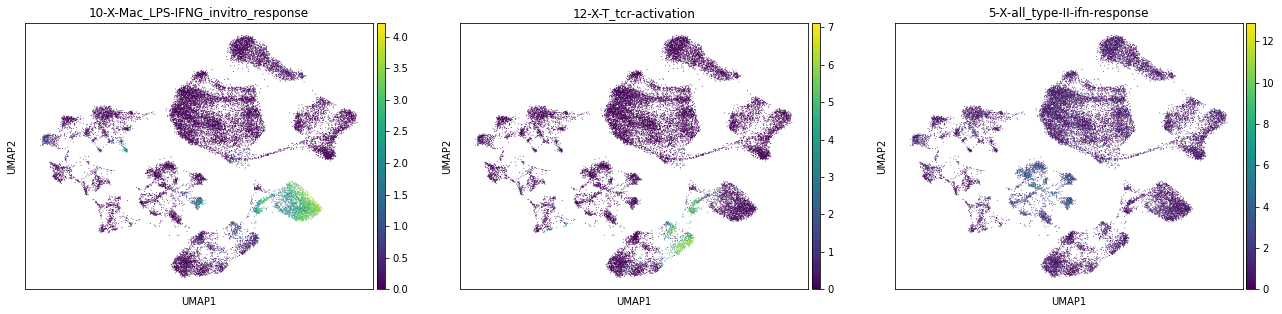

In [66]:
sc.pl.umap(adata, color = factors_of_interest, s = 3, cmap='viridis', legend_fontsize = 10, vmin=0,palette=color_map_clusters_nogrey,
          save='Kartha_stimulation_tsne.svg')

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


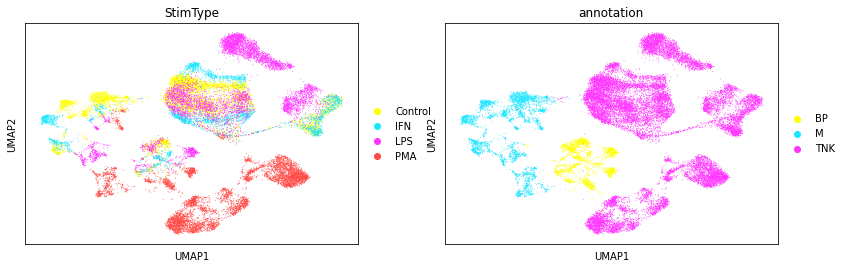

In [67]:
sc.pl.umap(adata, color = ['StimType','annotation'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette=color_map_clusters_nogrey,
          save='Kartha_stimulation_SLALOM_tsne.svg')

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


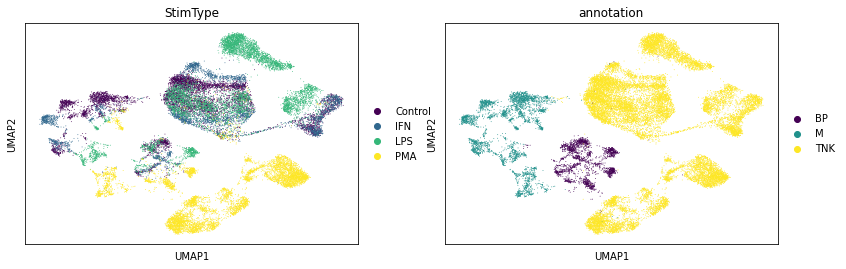

In [68]:
sc.pl.umap(adata, color = ['StimType','annotation'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette='viridis',
          save='Kartha_stimulation_celltypes_umap_SLALOM_viridis.svg')

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


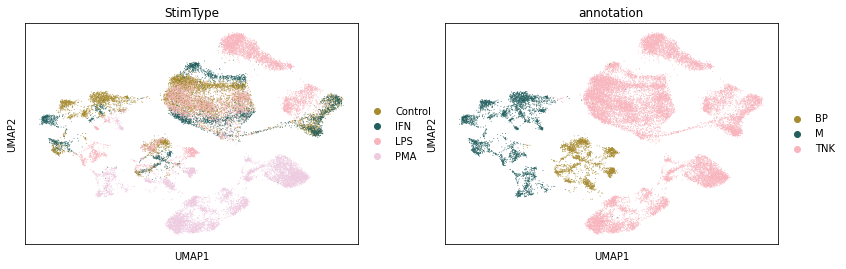

In [69]:
sc.pl.umap(adata, color = ['StimType','annotation'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette=batlow_20,
          save='Kartha_stimulation_celltypes_umap_SLALOM_batlow.svg')

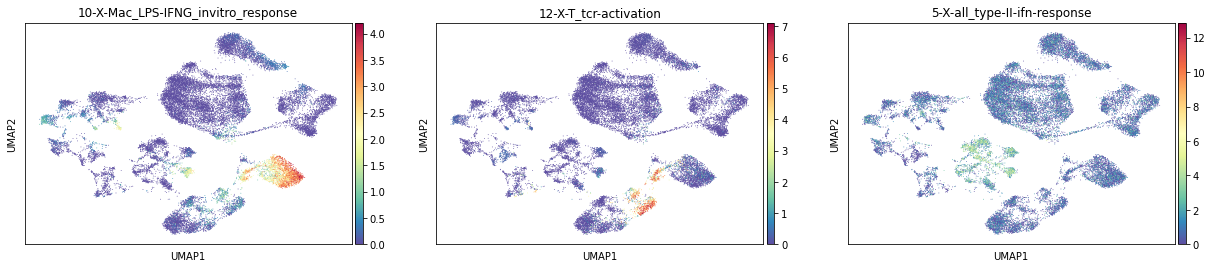

In [70]:
sc.pl.umap(adata, color = factors_of_interest, s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,
          save='Kartha_stimulation_SLALOM_tsne.svg')

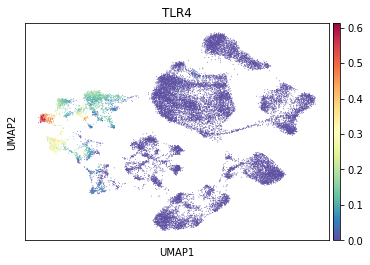

In [71]:
sc.pl.umap(adata, color = 'TLR4', s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,
          save='Kartha_TLR4_SLALOM_tsne.svg',layer='imputed')

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


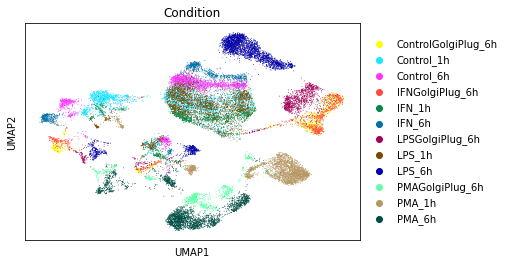

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


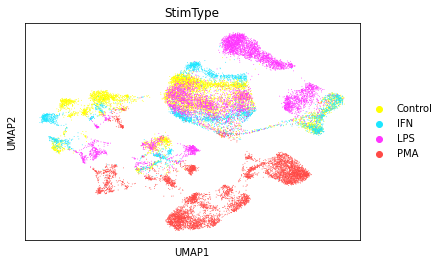

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


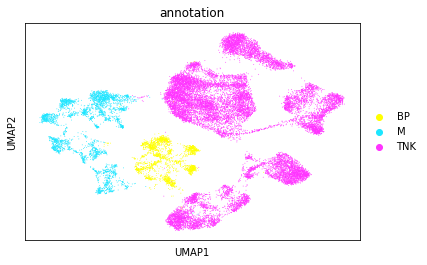

In [72]:
sc.pl.umap(adata, color = ['Condition'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette=color_map_clusters_nogrey,
          save='Kartha_stimulation_SLALOM_tsne.svg')
sc.pl.umap(adata, color = ['StimType'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette=color_map_clusters_nogrey,
          save='Kartha_stimulation_SLALOM_tsne.svg')
sc.pl.umap(adata, color = ['annotation'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette=color_map_clusters_nogrey,
          save='Kartha_stimulation_SLALOM_tsne.svg')

In [73]:
adata_celltype = adata[adata.obs['Condition'].isin(['ControlGolgiPlug_6h','IFNGolgiPlug_6h','LPSGolgiPlug_6h','PMAGolgiPlug_6h'])]
adata_celltype

View of AnnData object with n_obs × n_vars = 4486 × 19004
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation', 'SLALOM_0', 'SLALOM_1', 'SLALOM_2', 'SLALOM_3', 'SLALOM_4', 'SLALOM_5', 'SLALOM_6', 'SLALOM_7', 'SLALOM_8', 'SLALOM_9', 'SLALOM_10', 'SLALOM_11', 'SLALOM_12', '0-X-0', '1-X-1', '2-X-2', '3-X-3', '4-X-4', '5-X-all_type-II-ifn-response', '6-X-all_type-II-ifn-response', '7-X-7', '8-X-all_type-II-ifn-response', '9-X-9', '10-X-Mac_LPS-IFNG_invitro_response', '11-X-11', '12-X-T_tcr-activation'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'spectra_vocab'
    uns: 'SLALOM_markers_g

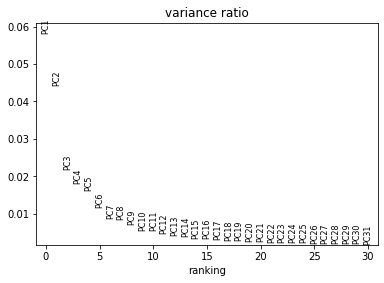

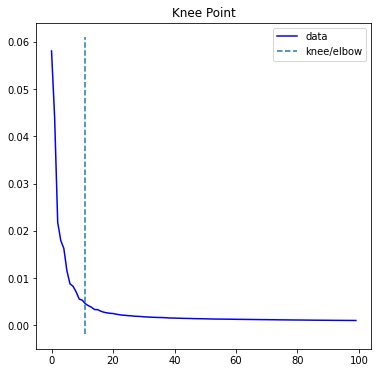

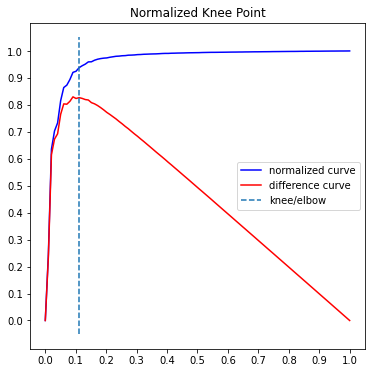

Kneepoint happens at PC: 11
11 PC explain 20.47228333290935 % of variance
2 PC explain 10.211138113129998 % of variance
3 PC explain 12.391955073611337 % of variance
4 PC explain 14.18786500837815 % of variance
5 PC explain 15.813842361672616 % of variance
6 PC explain 16.96896910357758 % of variance
7 PC explain 17.846741689508775 % of variance
8 PC explain 18.67390491964992 % of variance
9 PC explain 19.382557167713678 % of variance
10 PC explain 19.93899869779982 % of variance
11 PC explain 20.47228333290935 % of variance
12 PC explain 20.929934097685017 % of variance
13 PC explain 21.34631750608961 % of variance
14 PC explain 21.729218386550084 % of variance
15 PC explain 22.06435653698051 % of variance
16 PC explain 22.397411870028524 % of variance
17 PC explain 22.697829619069353 % of variance
18 PC explain 22.97681856645277 % of variance
19 PC explain 23.242097744624903 % of variance
20 PC explain 23.498258657089824 % of variance
21 PC explain 23.749412884974344 % of variance
22

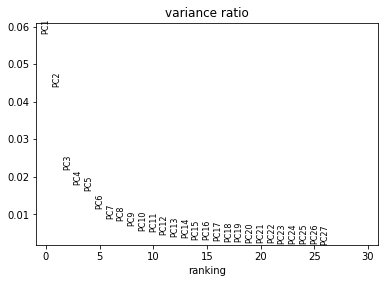

In [74]:
number_of_PC_used = calculate_optimal_PC(adata_celltype, min_PC = 20, min_var=25, n_comps=100, use_hv=None)
sc.pp.neighbors(adata_celltype, n_neighbors=15, method= 'umap',  n_pcs=number_of_PC_used,
                random_state=0)

In [75]:
#recalc umap
sc.tl.umap(adata_celltype,random_state=0)

In [81]:
adata_celltype = randomize_cells(adata_celltype)

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


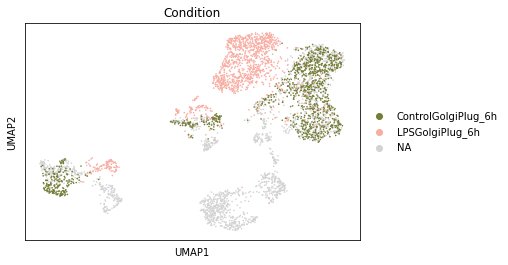

In [82]:
sc.pl.umap(adata_celltype, color = ['Condition'],groups=['ControlGolgiPlug_6h','LPSGolgiPlug_6h'], s = 10, 
           legend_fontsize = 10, vmin=0,palette=batlow_20[4:],
          save='LPSGolgiPlug_6h.svg')

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


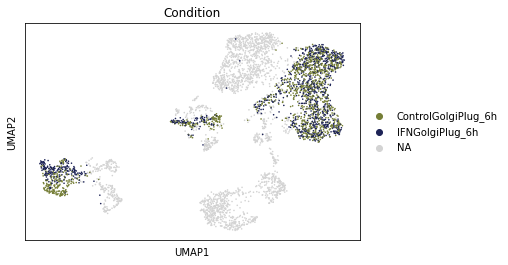

In [83]:
sc.pl.umap(adata_celltype, color = ['Condition'],groups=['ControlGolgiPlug_6h','IFNGolgiPlug_6h'], s = 10, 
           legend_fontsize = 10, vmin=0,palette=batlow_20[4:],
          save='IFNGolgiPlug_6h.svg')

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


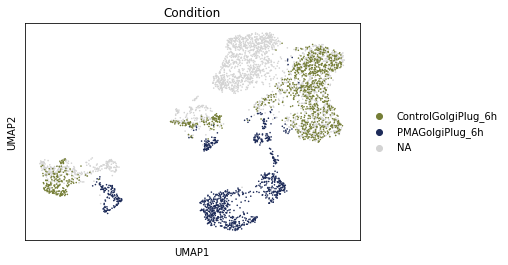

In [84]:
sc.pl.umap(adata_celltype, color = ['Condition'],groups=['ControlGolgiPlug_6h','PMAGolgiPlug_6h'], s = 10, 
           legend_fontsize = 10, vmin=0,palette=batlow_20[4:],
          save='PMAGolgiPlug_6h_SLALOM.svg')

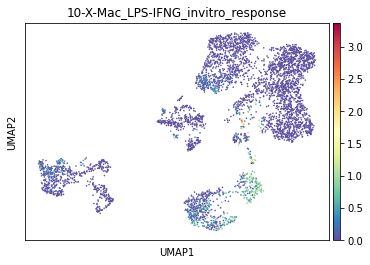

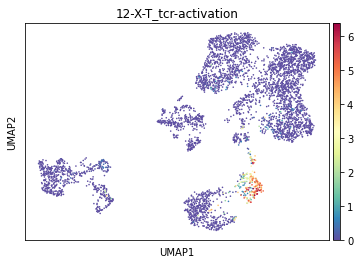

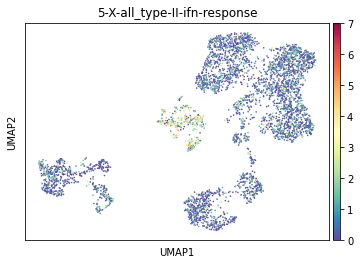

In [85]:
sc.pl.umap(adata_celltype, color = factors_of_interest[0], s = 10, cmap='Spectral_r', legend_fontsize = 10, vmin=0,
          save='Kartha_LPSstimulation_umap_SLALOM.svg')
sc.pl.umap(adata_celltype, color = factors_of_interest[1], s = 10, cmap='Spectral_r', legend_fontsize = 10, vmin=0,
          save='Kartha_TCRstimulation_umap_SLALOM.svg')
sc.pl.umap(adata_celltype, color = factors_of_interest[2], s = 10, cmap='Spectral_r', legend_fontsize = 10, vmin=0,
          save='Kartha_IFNGstimulation_umap_SLALOM.svg')


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


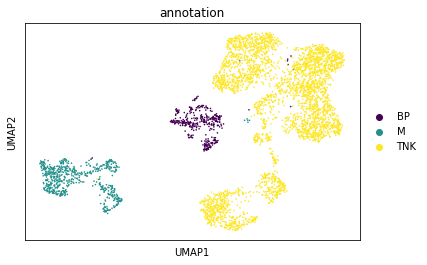

In [86]:
sc.pl.umap(adata_celltype, color = ['annotation'],s = 10, 
           legend_fontsize = 10, vmin=0,palette='viridis',
          save='annotation_SLALOM.svg')

In [87]:
adata_celltype.obs['batch'] = adata_celltype.obs['Condition'].str.cat(adata_celltype.obs['Donor'],sep='_')
adata_celltype.obs['batch']

cellBarcode
ControlGolgiPlug_6h_Donor1_gtgtccatccagttcgtagcc    ControlGolgiPlug_6h_Donor1
PMAGolgiPlug_6h_Donor3_tcggcgttcaagaccaggcgg            PMAGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor1_tttggtcgatcacctccgctc            PMAGolgiPlug_6h_Donor1
LPSGolgiPlug_6h_Donor1_cctccttcttaccggcctcgt            LPSGolgiPlug_6h_Donor1
ControlGolgiPlug_6h_Donor2_aaccacatcaagaccatctta    ControlGolgiPlug_6h_Donor2
                                                               ...            
IFNGolgiPlug_6h_Donor2_cttcatcctattcgtcttgta            IFNGolgiPlug_6h_Donor2
LPSGolgiPlug_6h_Donor3_ctaagaagcacagcttaagcg            LPSGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor2_tccgctcgcgactcattcgtt            PMAGolgiPlug_6h_Donor2
LPSGolgiPlug_6h_Donor2_gtggcgcttgaggcaagtgcg            LPSGolgiPlug_6h_Donor2
LPSGolgiPlug_6h_Donor1_tttggtcacagcttcgcaatc            LPSGolgiPlug_6h_Donor1
Name: batch, Length: 4486, dtype: object

In [90]:
#mean exp per donor
plot_df_list = []

for i in set(adata_celltype.obs['annotation']):
    adata_celltype_sub = adata_celltype[adata_celltype.obs['annotation']==i]
    plot_df_list.append(aggregate_cell_scores(adata_celltype_sub,'Condition','annotation',factors_of_interest,'batch','Donor',
                            ['Condition','annotation','Donor'],
                            zero_cutoff =None))
plot_df_list

[                            10-X-Mac_LPS-IFNG_invitro_response  \
 LPSGolgiPlug_6h_Donor3                               -0.712109   
 PMAGolgiPlug_6h_Donor1                               -1.041691   
 PMAGolgiPlug_6h_Donor2                               -1.108678   
 IFNGolgiPlug_6h_Donor2                               -0.089535   
 ControlGolgiPlug_6h_Donor2                           -0.220858   
 ControlGolgiPlug_6h_Donor3                           -0.229708   
 IFNGolgiPlug_6h_Donor3                               -0.184296   
 LPSGolgiPlug_6h_Donor1                               -0.786889   
 IFNGolgiPlug_6h_Donor1                                0.018517   
 PMAGolgiPlug_6h_Donor3                               -1.205056   
 LPSGolgiPlug_6h_Donor2                               -0.953731   
 ControlGolgiPlug_6h_Donor1                           -0.008634   
 
                                       Condition annotation   Donor  \
 LPSGolgiPlug_6h_Donor3          LPSGolgiPlug_6h        

In [108]:
plot_df = pd.concat(plot_df_list).fillna(0)
plot_df

,10-X-Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,12-X-T_tcr-activation,5-X-all_type-II-ifn-response
LPSGolgiPlug_6h_Donor3,-0.712109,LPSGolgiPlug_6h,M,Donor3,-0.179221,-0.754454
PMAGolgiPlug_6h_Donor1,-1.041691,PMAGolgiPlug_6h,M,Donor1,-0.456702,0.291349
PMAGolgiPlug_6h_Donor2,-1.108678,PMAGolgiPlug_6h,M,Donor2,-0.548832,0.056537
IFNGolgiPlug_6h_Donor2,-0.089535,IFNGolgiPlug_6h,M,Donor2,-0.127182,0.490426
ControlGolgiPlug_6h_Donor2,-0.220858,ControlGolgiPlug_6h,M,Donor2,-0.253686,-0.950971
ControlGolgiPlug_6h_Donor3,-0.229708,ControlGolgiPlug_6h,M,Donor3,-0.234350,-0.751283
IFNGolgiPlug_6h_Donor3,-0.184296,IFNGolgiPlug_6h,M,Donor3,-0.163604,-0.144764
LPSGolgiPlug_6h_Donor1,-0.786889,LPSGolgiPlug_6h,M,Donor1,0.034542,-1.531988
IFNGolgiPlug_6h_Donor1,0.018517,IFNGolgiPlug_6h,M,Donor1,-0.114215,-0.098113
PMAGolgiPlug_6h_Donor3,-1.205056,PMAGolgiPlug_6h,M,Donor3,-0.713069,-0.096323


In [114]:
plot_df_LPS = plot_df[plot_df['Condition'].isin(['LPSGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_LPS

,10-X-Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,12-X-T_tcr-activation,5-X-all_type-II-ifn-response
LPSGolgiPlug_6h_Donor3,-0.712109,LPSGolgiPlug_6h,M,Donor3,-0.179221,-0.754454
ControlGolgiPlug_6h_Donor2,-0.220858,ControlGolgiPlug_6h,M,Donor2,-0.253686,-0.950971
ControlGolgiPlug_6h_Donor3,-0.229708,ControlGolgiPlug_6h,M,Donor3,-0.234350,-0.751283
LPSGolgiPlug_6h_Donor1,-0.786889,LPSGolgiPlug_6h,M,Donor1,0.034542,-1.531988
LPSGolgiPlug_6h_Donor2,-0.953731,LPSGolgiPlug_6h,M,Donor2,-0.126116,-1.403784
ControlGolgiPlug_6h_Donor1,-0.008634,ControlGolgiPlug_6h,M,Donor1,-0.179094,-0.507198
LPSGolgiPlug_6h_Donor3,-0.378338,LPSGolgiPlug_6h,BP,Donor3,-0.272741,1.611667
ControlGolgiPlug_6h_Donor2,-0.625485,ControlGolgiPlug_6h,BP,Donor2,-0.361158,1.718588
ControlGolgiPlug_6h_Donor3,-0.439693,ControlGolgiPlug_6h,BP,Donor3,-0.466635,2.757319
LPSGolgiPlug_6h_Donor1,-0.319630,LPSGolgiPlug_6h,BP,Donor1,-0.259813,1.399492


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#000000'` for same effect.
  warnings.warn(msg, FutureWarning)


Kartha_celltype_LPS_boxplot_SLALOM10-X-Mac_LPS-IFNG_invitro_response.svg


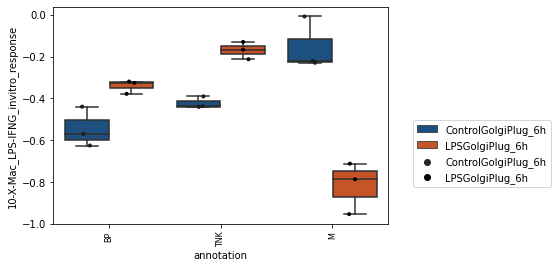

In [116]:
#plot
factor='10-X-Mac_LPS-IFNG_invitro_response'
save_name ='Kartha_celltype_LPS_boxplot_SLALOM'+factor+'.svg'
hue_order = ['ControlGolgiPlug_6h','LPSGolgiPlug_6h']
order_list = ['BP','TNK','M']
sns.boxplot(data=plot_df_LPS,x='annotation', 
                y=factor, hue='Condition', order=order_list, hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_LPS,x='annotation', 
                y=factor, hue='Condition', order=order_list, hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)

In [120]:
plot_df_IFN = plot_df[plot_df['Condition'].isin(['IFNGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_IFN

,10-X-Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,12-X-T_tcr-activation,5-X-all_type-II-ifn-response
IFNGolgiPlug_6h_Donor2,-0.089535,IFNGolgiPlug_6h,M,Donor2,-0.127182,0.490426
ControlGolgiPlug_6h_Donor2,-0.220858,ControlGolgiPlug_6h,M,Donor2,-0.253686,-0.950971
ControlGolgiPlug_6h_Donor3,-0.229708,ControlGolgiPlug_6h,M,Donor3,-0.234350,-0.751283
IFNGolgiPlug_6h_Donor3,-0.184296,IFNGolgiPlug_6h,M,Donor3,-0.163604,-0.144764
IFNGolgiPlug_6h_Donor1,0.018517,IFNGolgiPlug_6h,M,Donor1,-0.114215,-0.098113
ControlGolgiPlug_6h_Donor1,-0.008634,ControlGolgiPlug_6h,M,Donor1,-0.179094,-0.507198
IFNGolgiPlug_6h_Donor2,-0.521215,IFNGolgiPlug_6h,BP,Donor2,-0.308456,2.341499
ControlGolgiPlug_6h_Donor2,-0.625485,ControlGolgiPlug_6h,BP,Donor2,-0.361158,1.718588
ControlGolgiPlug_6h_Donor3,-0.439693,ControlGolgiPlug_6h,BP,Donor3,-0.466635,2.757319
IFNGolgiPlug_6h_Donor3,-0.561630,IFNGolgiPlug_6h,BP,Donor3,-0.365837,1.782210


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#000000'` for same effect.
  warnings.warn(msg, FutureWarning)


Kartha_celltype_IFN_boxplot_SLALOM5-X-all_type-II-ifn-response.svg


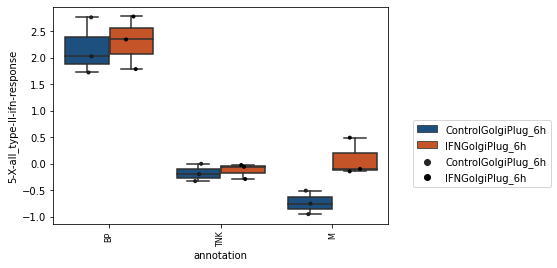

In [121]:
#plot
factor='5-X-all_type-II-ifn-response'
save_name ='Kartha_celltype_IFN_boxplot_SLALOM'+factor+'.svg'
hue_order = ['ControlGolgiPlug_6h','IFNGolgiPlug_6h']
order_list = ['BP','TNK','M']

sns.boxplot(data=plot_df_IFN,x='annotation', 
                y=factor, hue='Condition', order=order_list, hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_IFN,x='annotation', 
                y=factor, hue='Condition', order=order_list, hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.ylim(0,3.5)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)

In [125]:
plot_df_IFN[plot_df_IFN['Condition']== hue_order[0]]

,10-X-Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,12-X-T_tcr-activation,5-X-all_type-II-ifn-response,comparison
ControlGolgiPlug_6h_Donor2,-0.220858,ControlGolgiPlug_6h,M,Donor2,-0.253686,-0.950971,False
ControlGolgiPlug_6h_Donor3,-0.229708,ControlGolgiPlug_6h,M,Donor3,-0.234350,-0.751283,False
ControlGolgiPlug_6h_Donor1,-0.008634,ControlGolgiPlug_6h,M,Donor1,-0.179094,-0.507198,False
ControlGolgiPlug_6h_Donor2,-0.625485,ControlGolgiPlug_6h,BP,Donor2,-0.361158,1.718588,False
ControlGolgiPlug_6h_Donor3,-0.439693,ControlGolgiPlug_6h,BP,Donor3,-0.466635,2.757319,False
ControlGolgiPlug_6h_Donor1,-0.570000,ControlGolgiPlug_6h,BP,Donor1,-0.354762,2.022854,False
ControlGolgiPlug_6h_Donor2,-0.390633,ControlGolgiPlug_6h,TNK,Donor2,-0.264834,-0.001200,False
ControlGolgiPlug_6h_Donor3,-0.437275,ControlGolgiPlug_6h,TNK,Donor3,-0.258316,-0.197356,False
ControlGolgiPlug_6h_Donor1,-0.440770,ControlGolgiPlug_6h,TNK,Donor1,-0.251331,-0.328210,False


In [126]:
plot_df_TCR = plot_df[plot_df['Condition'].isin(['PMAGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_TCR

,10-X-Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,12-X-T_tcr-activation,5-X-all_type-II-ifn-response
PMAGolgiPlug_6h_Donor1,-1.041691,PMAGolgiPlug_6h,M,Donor1,-0.456702,0.291349
PMAGolgiPlug_6h_Donor2,-1.108678,PMAGolgiPlug_6h,M,Donor2,-0.548832,0.056537
ControlGolgiPlug_6h_Donor2,-0.220858,ControlGolgiPlug_6h,M,Donor2,-0.253686,-0.950971
ControlGolgiPlug_6h_Donor3,-0.229708,ControlGolgiPlug_6h,M,Donor3,-0.234350,-0.751283
PMAGolgiPlug_6h_Donor3,-1.205056,PMAGolgiPlug_6h,M,Donor3,-0.713069,-0.096323
ControlGolgiPlug_6h_Donor1,-0.008634,ControlGolgiPlug_6h,M,Donor1,-0.179094,-0.507198
PMAGolgiPlug_6h_Donor1,-0.523302,PMAGolgiPlug_6h,BP,Donor1,-0.533186,1.505989
PMAGolgiPlug_6h_Donor2,-0.556640,PMAGolgiPlug_6h,BP,Donor2,-0.604439,1.663986
ControlGolgiPlug_6h_Donor2,-0.625485,ControlGolgiPlug_6h,BP,Donor2,-0.361158,1.718588
ControlGolgiPlug_6h_Donor3,-0.439693,ControlGolgiPlug_6h,BP,Donor3,-0.466635,2.757319


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#000000'` for same effect.
  warnings.warn(msg, FutureWarning)


Kartha_celltype_TCR_boxplot_SLALOM12-X-T_tcr-activation.svg


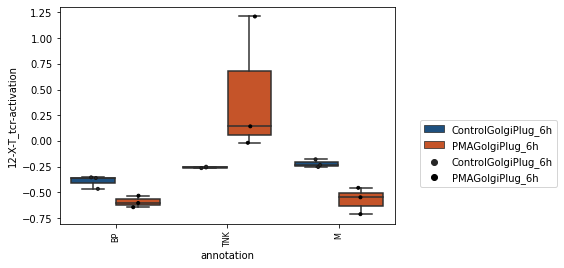

In [127]:
#plot
factor='12-X-T_tcr-activation'
save_name ='Kartha_celltype_TCR_boxplot_SLALOM'+factor+'.svg'
hue_order = ['ControlGolgiPlug_6h','PMAGolgiPlug_6h']
order_list = ['BP','TNK','M']
sns.boxplot(data=plot_df_TCR,x='annotation', 
                y=factor, hue='Condition', order=order_list, hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_TCR,x='annotation', 
                y=factor, hue='Condition', order=order_list, hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)